In [ ]:
# Which public health factors have the greatest impact on life expectancy by country 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import plot_module as plm

In [2]:
df = pd.read_csv('refined_life_expect.csv')
print(df.shape)

#remove fragmanted data
df.dropna(inplace=True)

# make sure that there's still enough data to work with
print(df.shape)

(2938, 19)
(1649, 19)


In [ ]:
# check for correlations between the different variables
sns.pairplot(df, diag_kind="kde", height=2.5)
# plt.savefig('pairedplots_all.png')

In [3]:
# from the paired plot using the columns we believe alcohol, bmi, hiv, gdp, 
# children malnutrition, average education, country size (small/medium/big), 
# the ratio between adult to infant mortality, the interactions between bmi+alcohol (lifestyle), 
# and the interaction between population+gdp might effect the life expectancy

new_df = pd.DataFrame({'life_expectancy': df['life_expectancy'],
                        'alcohol': df['alcohol'],
                        'bmi': df['bmi'],
                        'hiv': df['hiv'],
                        'gdp': df['gdp'],
                        'thinness_till19': df['thinness_till19'],
                        'inf_death': df['inf_death'],
                        'school': df['school'],
                        'death_ratio': df['death_ratio'],
                        'lifestyle': df['bmi']*df['alcohol'],
                        'pop_gdp': df['gdp']*df['pop_size'],
                        'pop_size': df['pop_size'],
                        })

# check for multicollinearity and remove highgly correlated variables
corr_map = new_df.corr()
# corr_map

In [ ]:
# Example 1: Correlation between average education and life expectancy
plm.create_scatter(new_df['school'], new_df['life_expectancy'], 'Life Expectancy and Education', 
                   'Education (Years)', 'Life Expectancy (Years)', 'edu_scat')         
# np.corrcoef(new_df['school'], new_df['life_expectancy'])

In [ ]:
# Example 2: Correlation between log transformed value of GDP and life expectancy
plm.create_scatter(np.log(new_df['gdp']), new_df['life_expectancy'], 'Life Expectancy and GDP', 
                   'GDP (log)', 'Life Expectancy (Years)', 'gdp_scat')         

In [ ]:
plm.create_hist(new_df['school'], title="Education in Years", xlabel="Education") 

In [ ]:
# Create a heatmap for all our variables
CorrMtx(corr_map)

(1649, 12)

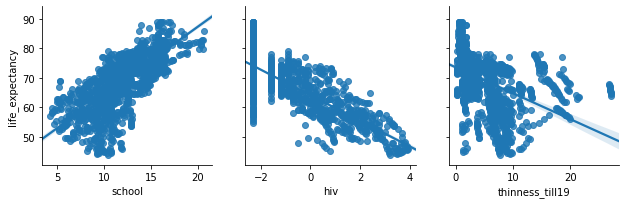

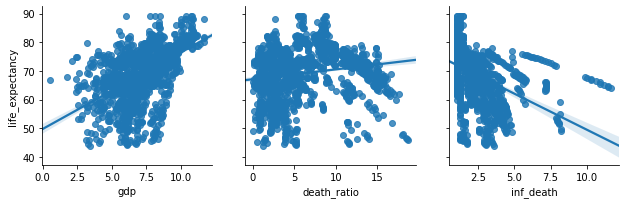

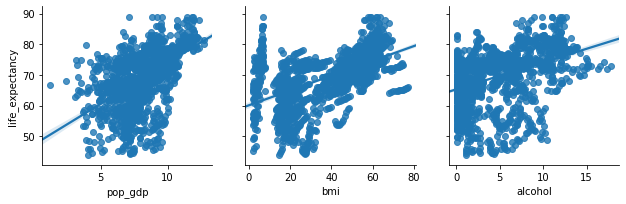

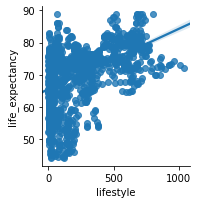

In [6]:
# before running the model we removed the outliers
depended = ['life_expectancy']
features = ['school', 'hiv', 'thinness_till19', 'gdp',
            'death_ratio', 'inf_death', 'pop_gdp', 'bmi',
            'alcohol', 'lifestyle'] 

# looking at our data again to try and locate outliers
plm.get_pairs(new_df, depended, features, 3)
new_df.shape

In [ ]:
# transform our independent variable to look more normally distrubuted
new_df.hiv = new_df['hiv'].apply(np.log)
new_df.pop_gdp = new_df['pop_gdp'].apply(np.log)
new_df.gdp = new_df['gdp'].apply(np.log)
new_df.inf_death =new_df['inf_death'].apply(np.cbrt)
new_df.death_ratio = new_df['death_ratio'].apply(np.sqrt)

(1635, 12)

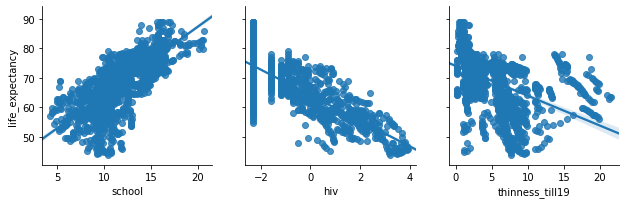

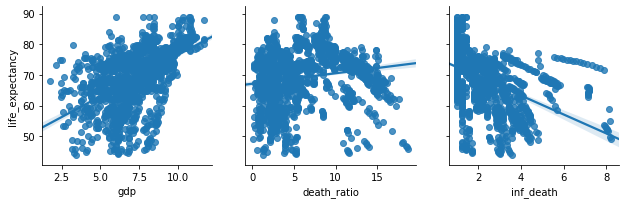

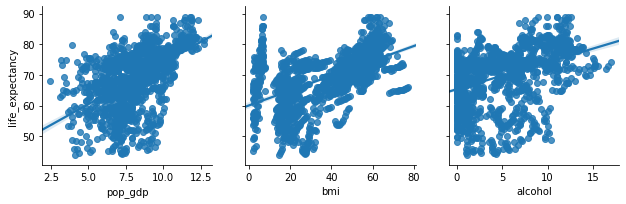

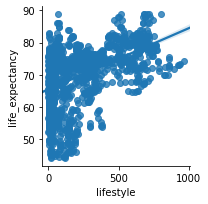

In [7]:
# remove outliers and check the amount of data that we left
new_df = new_df[new_df.gdp > 1.25] 
new_df = new_df[new_df.thinness_till19 < 25]
new_df = new_df[new_df.lifestyle < 1000]

plm.get_pairs(new_df, depended, features, 3)
new_df.shape

c:\users\gilor\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


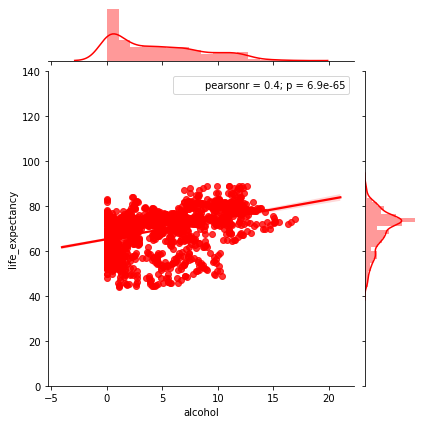

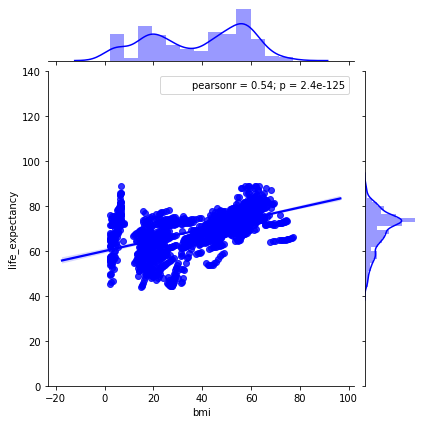

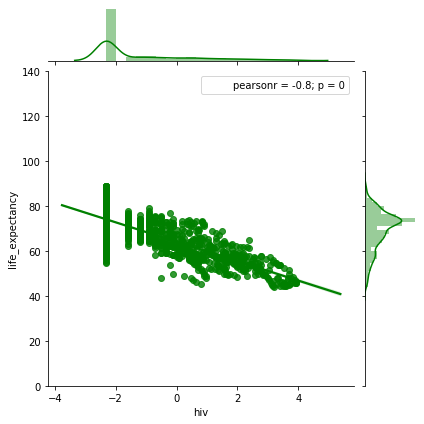

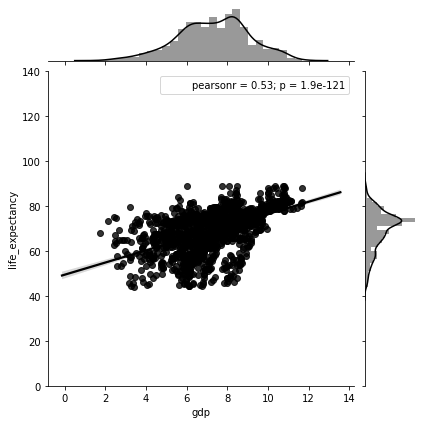

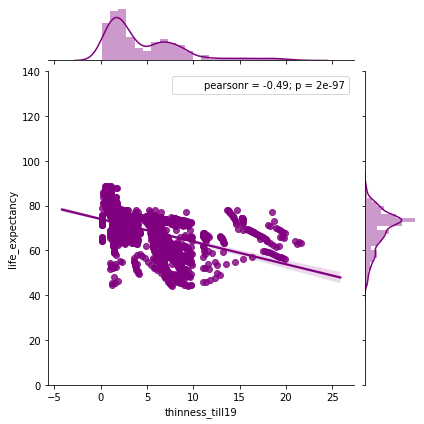

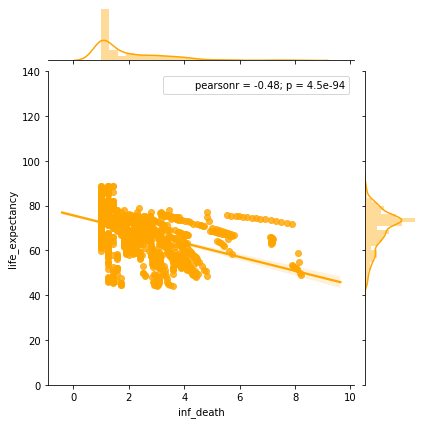

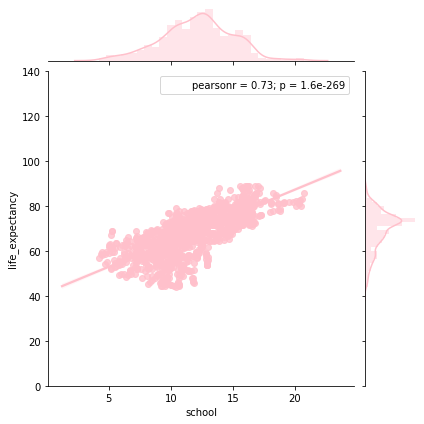

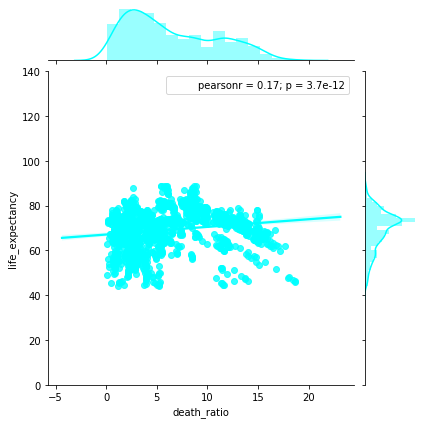

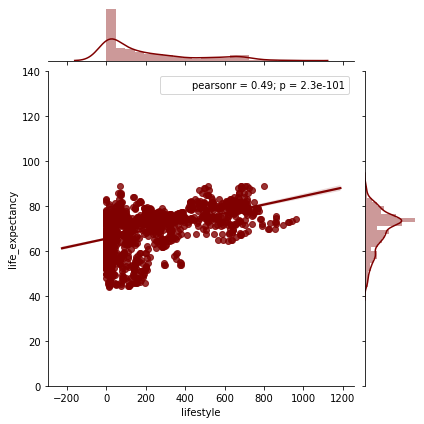

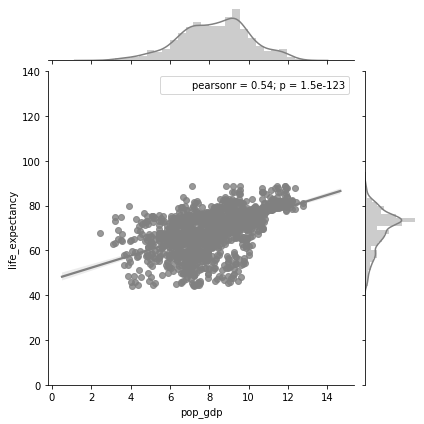

In [8]:
# Using seaborn to create scatters and distribution graphs for our possible 
colors = ['red','blue','green','black','purple','orange','pink', 'cyan','maroon', 'gray']
count = 0 
for column in new_df.columns[1:-1]:
    plots = sns.jointplot(x=column, y='life_expectancy', data=new_df, kind='reg', ylim=(0,140), color=colors[count])
    plots.annotate(stats.pearsonr)
    count += 1

In [9]:
# first model to test our feature's significance
lr_model_init = ols(formula='life_expectancy~bmi+alcohol+hiv+gdp+thinness_till19+inf_death+C(pop_size)+school+death_ratio+lifestyle+pop_gdp', data=new_df).fit()
lr_model_init.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     667.1
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:04:40   Log-Likelihood:                -4547.4
No. Observations:                1635   AIC:                             9117.
Df Residuals:                    1624   BIC:                             9176.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           44.8844      0.751     59.751      0.000      43.411      46.358
C(pop_size)[T.3]    -5.5739      0.227    -24.536      0.000      -6.019      -5.128
bmi                  0.0050      0.009      0.545      0.585      -0.013       0.023
alcohol              0.0766      0.066      1.160      0.246      -0.053       0.206
hiv                 -3.0061      0.073    -41.107      0.000      -3.150      -2.863
gdp                -14.1676      0.251    -56.385      0.000     -14.660     -13.675
thinness_till19     -0.1274      0.030     -4.217      0.000      -0.187      -0.068
inf_death           -1.0334      0.113     -9.159      0.000      -1.255      -0.812
school               0.8360      0.060     13.916      0.000       0.718       0.954
death_ratio         -0.2156      0.030     -7.132      0.000      -0.275      -0.156
lifestyle            0.0003      0.001      0.255      0.799      -0.002       0.003
pop_gdp             14.6839      0.230     63.975      0.000      14.234      15.134
==============================================================================
Omnibus:                       13.024   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.142
Skew:                          -0.066   Prob(JB):                     0.000115
Kurtosis:                       3.499   Cond. No.                     5.96e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.35e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

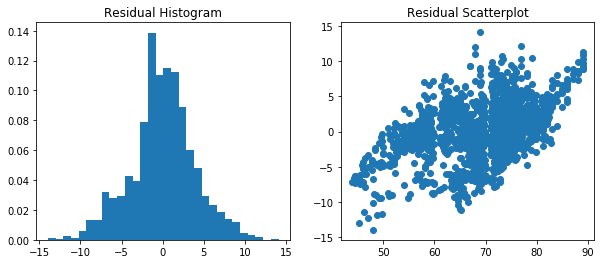

In [10]:
 plm.checkresiduals(new_df, 'life_expectancy', lr_model_init)

In [17]:
#adjusting the model - remove features that were not statistically significant (alcohol, bmi, lifestyle)
lr_model_inter = ols(formula='life_expectancy~+hiv+gdp+thinness_till19+inf_death+school+death_ratio+pop_gdp+C(pop_size)', data=new_df).fit()
lr_model_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     948.3
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:17:25   Log-Likelihood:                -4551.8
No. Observations:                1635   AIC:                             9120.
Df Residuals:                    1627   BIC:                             9163.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           44.3632      0.680     65.219      0.000      43.029      45.697
C(pop_size)[T.3]    -5.5171      0.225    -24.541      0.000      -5.958      -5.076
hiv                 -2.9757      0.070    -42.467      0.000      -3.113      -2.838
gdp                -13.9793      0.227    -61.459      0.000     -14.425     -13.533
thinness_till19     -0.1507      0.027     -5.509      0.000      -0.204      -0.097
inf_death           -1.0124      0.111     -9.110      0.000      -1.230      -0.794
school               0.9189      0.053     17.367      0.000       0.815       1.023
death_ratio         -0.2080      0.030     -6.920      0.000      -0.267      -0.149
pop_gdp             14.5339      0.206     70.478      0.000      14.129      14.938
==============================================================================
Omnibus:                       12.031   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.885
Skew:                          -0.044   Prob(JB):                     0.000216
Kurtosis:                       3.490   Cond. No.                     3.63e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.36e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

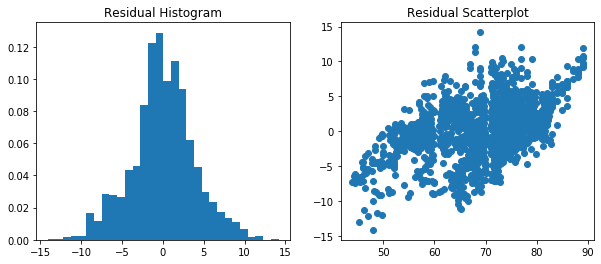

In [18]:
plm.checkresiduals(new_df, 'life_expectancy', lr_model_inter)

In [22]:
# Scaling the data set
independent = ['school', 'hiv', 'thinness_till19',
               'death_ratio', 'inf_death', 'pop_gdp',
               'gdp', 'pop_size'] 

scaler = StandardScaler()
scaler.fit(new_df[independent])
scaled_features = scaler.transform(new_df[independent])

# create a scaled dataframe
scaled_features_df = pd.DataFrame(scaled_features, columns=independent, index=new_df.index)
scaled_features_df.head()

# running the model again
scaled_features_model = sm.OLS(endog=new_df['life_expectancy'], exog=sm.add_constant(scaled_features_df)).fit()
scaled_features_model.summary()

c:\users\gilor\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     948.3
Date:                Thu, 22 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:23:55   Log-Likelihood:                -4551.8
No. Observations:                1635   AIC:                             9120.
Df Residuals:                    1627   BIC:                             9163.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              69.3221      0.097    714.050      0.000      69.132      69.513
school              2.5722      0.148     17.367      0.000       2.282       2.863
hiv                -4.8501      0.114    -42.467      0.000      -5.074      -4.626
thinness_till19    -0.6389      0.116     -5.509      0.000      -0.866      -0.411
death_ratio        -0.9192      0.133     -6.920      0.000      -1.180      -0.659
inf_death          -1.3812      0.152     -9.110      0.000      -1.679      -1.084
pop_gdp             0.4903      0.061      8.037      0.000       0.371       0.610
gdp                 0.4803      0.062      7.719      0.000       0.358       0.602
pop_size            0.1249      0.098      1.276      0.202      -0.067       0.317
==============================================================================
Omnibus:                       12.031   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.885
Skew:                          -0.044   Prob(JB):                     0.000216
Kurtosis:                       3.490   Cond. No.                     3.78e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  4e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

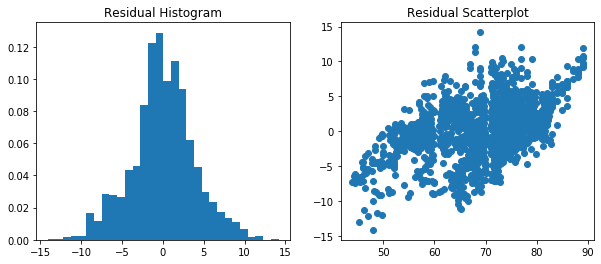

In [21]:
plm.checkresiduals(new_df, 'life_expectancy', scaled_features_model)

Mean absolete error: 3.082329962751478
Mean squared error: 16.944079751915773
Root squared error: 4.116318713597839


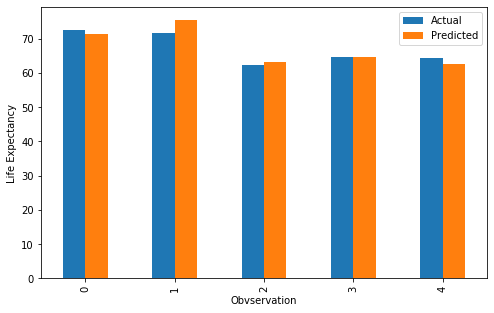

In [33]:
# removing bmi, gdp, population size from testing that were deemed insignificant in past models
X = new_df[['hiv','pop_gdp', 'death_ratio','school', 'thinness_till19', 'inf_death',]].values
y = new_df.life_expectancy.values.reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train, y_train)
# print(model.intercept_)
# print(model.coef_)

y_predict = model.predict(x_test)
predict_df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_predict.flatten()})
plot_df = predict_df.head(5)
plot_df.plot(kind='bar', figsize=(8,5))
plt.ylabel('Life Expectancy')
plt.xlabel('Obvservation')


print('Mean absolete error:', metrics.mean_absolute_error(y_test, y_predict))
print('Mean squared error:', metrics.mean_squared_error(y_test, y_predict))
print('Root squared error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

Mean absolete error: 3.053876023766805
Mean squared error: 16.751239699146097
Moot squared error: 4.092827836489839


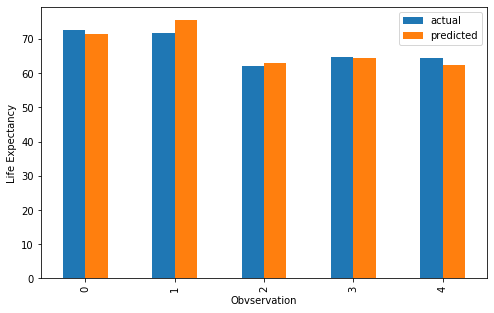

In [34]:
# adding the features that were considered insignificant to our model to test
X2 = new_df[['alcohol','bmi', 'pop_size', 'hiv','pop_gdp', 'death_ratio','school', 'thinness_till19', 'inf_death',]].values
y2 = new_df.life_expectancy.values.reshape(-1,1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(x_train2, y_train2)
# print(model.intercept_)
# print(model.coef_)

y_predict2 = model.predict(x_test2)
predict_df2 = pd.DataFrame({'actual': y_test2.flatten(), 'predicted': y_predict2.flatten()})
plot_df2 = predict_df2.head(5)
plot_df2.plot(kind='bar', figsize=(8,5))
plt.ylabel('Life Expectancy')
plt.xlabel('Obvservation')


print('Mean absolete error:', metrics.mean_absolute_error(y_test2, y_predict2))
print('Mean squared error:', metrics.mean_squared_error(y_test2, y_predict2))
print('Moot squared error:', np.sqrt(metrics.mean_squared_error(y_test2, y_predict2)))